# Credit Card Fraud – Anomaly Detection & Explainability

This notebook contains the One-Class SVM Model for the Altman dataset.

## Dependencies

In [ ]:
%pip -q install -U pip wheel setuptools

%pip -q install numpy pandas joblib cloudpickle

%pip -q install matplotlib seaborn

%pip -q install shap lime

%pip -q install scikit-learn

%pip -q install -U tensorflow keras

%pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com

print("All dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

## Imports

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path
import joblib
import json
import re
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
import shap
import lime
import lime.lime_tabular
from scipy.sparse import issparse

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings(
    "ignore",
    message="X has feature names, but",
    category=UserWarning
)

## Parameters

In [ ]:
drive.mount('/content/drive')
RESULTS_DIR = Path('/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/ocsvm')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
PREPROCESSOR_TYPE = 'kernel'

TRAIN_SAMPLE_SIZE = 30000

N_FRAUD_SAMPLES = 50
N_NORMAL_SAMPLES = 150
EVAL_PANEL_SIZE = N_FRAUD_SAMPLES + N_NORMAL_SAMPLES

BACKGROUND_SIZE = 500
SHAP_KMEANS_K = 100 # For summarizing background data for SHAP

# LIME Parameters
LIME_NUM_SAMPLES = 5000
LIME_KERNEL_WIDTH = 7.5
LIME_NUM_FEATURES = 15 # Number of features to show in LIME explanations
LIME_STABILITY_RUNS = 5
LIME_STABILITY_TOP_K = 5

# SHAP Parameters
SHAP_NSAMPLES = "auto"

Mounted at /content/drive


## Loading Data

In [ ]:
import numpy as np
from scipy.sparse import load_npz
from pathlib import Path
import json
import pickle g

PREPROCESSOR_TYPE = 'kernel'

DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/processed_data")
preprocessor_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/preprocessors")

preprocessor_file = preprocessor_dir / f"preprocessor_{PREPROCESSOR_TYPE}.pkl"
print(f"--- Loading preprocessor: {preprocessor_file} ---")

with open(preprocessor_file, 'rb') as f:
    preprocessor = pickle.load(f)

print("Preprocessor loaded successfully.")

def load_features(data_dir, preprocessor_type, data_name):
    """Loads pre-computed features, handling both sparse and dense formats."""
    base_path = data_dir / f"{data_name}_{preprocessor_type}"
    path_npz = base_path.with_suffix('.npz')
    path_npy = base_path.with_suffix('.npy')

    if path_npz.exists():
        print(f"Loading sparse data: {path_npz}")
        return load_npz(path_npz)
    elif path_npy.exists():
        print(f"Loading dense data: {path_npy}")
        return np.load(path_npy)
    else:
        raise FileNotFoundError(f"Data not found for base path: {base_path}")

print(f"\n--- Loading data for '{PREPROCESSOR_TYPE}' preprocessor ---")
X_train = load_features(DATA_DIR, PREPROCESSOR_TYPE, 'X_train_transformed')
X_test = load_features(DATA_DIR, PREPROCESSOR_TYPE, 'X_test_transformed')
y_train = np.load(DATA_DIR / "y_train.npy")
y_test = np.load(DATA_DIR / "y_test.npy")

# Explicitly convert to dense numpy arrays after loading
if issparse(X_train):
    print("Converting X_train to dense numpy array...")
    X_train = X_train.toarray()
if issparse(X_test):
    print("Converting X_test to dense numpy array...")
    X_test = X_test.toarray()

print("\nData loaded and converted to dense numpy arrays successfully.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

--- Loading preprocessor: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/preprocessors/preprocessor_kernel.pkl ---
Preprocessor loaded successfully.

--- Loading data for 'kernel' preprocessor ---
Loading sparse data: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/processed_data/X_train_transformed_kernel.npz
Loading sparse data: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/processed_data/X_test_transformed_kernel.npz
Converting X_train to dense numpy array...
Converting X_test to dense numpy array...

Data loaded and converted to dense numpy arrays successfully.
X_train shape: (978768, 165)
X_test shape: (244692, 165)
y_train shape: (978768,)
y_test shape: (244692,)


## One Class SVM

### Train and Evaluate Model

In [ ]:
X_train_normal = X_train[y_train == 0]
sample_indices = np.random.choice(X_train_normal.shape[0], TRAIN_SAMPLE_SIZE, replace=False)
X_train_sample = X_train_normal[sample_indices]
print(f"Training will use {X_train_sample.shape[0]} normal instances.")

# Train One-Class SVM
ocsvm_model = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)
print("Training One-Class SVM...")
ocsvm_model.fit(X_train_sample)
print("Training complete.")

print("\\n--- Evaluating Model on Full Test Set ---")
y_pred_raw = ocsvm_model.predict(X_test)
y_pred = np.where(y_pred_raw == -1, 1, 0) # Convert -1/1 to 1/0 for fraud/normal
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

model_performance = {
    'f1_score': f1_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, ocsvm_model.decision_function(X_test) * -1)
}

joblib.dump(ocsvm_model, RESULTS_DIR / f'ocsvm_model_{PREPROCESSOR_TYPE}_full.joblib')
print(f"\\nModel saved to {RESULTS_DIR}")

Training will use 30000 normal instances.
Training One-Class SVM...
Training complete.
\n--- Evaluating Model on Full Test Set ---
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97    243950
       Fraud       0.01      0.13      0.01       742

    accuracy                           0.95    244692
   macro avg       0.50      0.54      0.49    244692
weighted avg       0.99      0.95      0.97    244692

\nModel saved to /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/ocsvm


 Evaluation results saved to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/ocsvm/ocsvm_results_kernel.pkl
--- Generating Confusion Matrix for Full Model ---


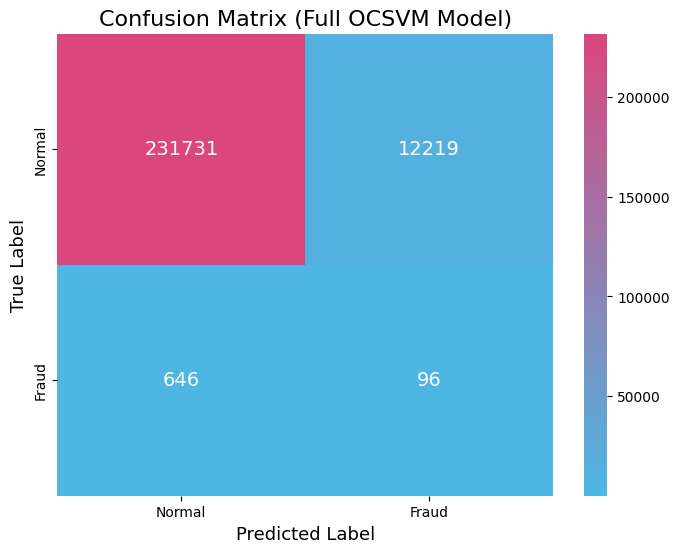

In [ ]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, classification_report
)
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom', ['#4db6e3', '#db467d'])

output_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/ocsvm")
output_dir.mkdir(parents=True, exist_ok=True)

ocsvm_results = {
    "model": ocsvm_model,
    "preprocessor_type": PREPROCESSOR_TYPE,
    "test_scores": model_performance
}

results_path = output_dir / f"ocsvm_results_{PREPROCESSOR_TYPE}.pkl"
with open(results_path, 'wb') as f:
    pickle.dump(ocsvm_results, f)

print(f" Evaluation results saved to: {results_path}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """
    Generates and displays a styled confusion matrix plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='g', cmap=custom_cmap,
                xticklabels=['Normal', 'Fraud'],
                yticklabels=['Normal', 'Fraud'],
                annot_kws={"size": 14})

    plt.xlabel('Predicted Label', fontsize=13)
    plt.ylabel('True Label', fontsize=13)
    plt.title(title, fontsize=16)
    plt.show()

print("--- Generating Confusion Matrix for Full Model ---")
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix (Full OCSVM Model)')

### Build Background & Evaluation Subsets

In [ ]:
background_indices = np.random.choice(X_train_sample.shape[0], BACKGROUND_SIZE, replace=False)
background_data = X_train_sample[background_indices]
background_data_summary = shap.kmeans(background_data, SHAP_KMEANS_K)
print(f"Background dataset created with {background_data.shape[0]} instances.")

# Create Explainability Evaluation Panel
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]
normal_samples = X_test_normal[np.random.choice(X_test_normal.shape[0], N_NORMAL_SAMPLES, replace=False)]
fraud_samples = X_test_fraud[np.random.choice(X_test_fraud.shape[0], N_FRAUD_SAMPLES, replace=False)]

eval_data = np.vstack([fraud_samples, normal_samples])
eval_labels = np.array([1]*N_FRAUD_SAMPLES + [0]*N_NORMAL_SAMPLES)
print(f"Explainability panel created with {eval_data.shape[0]} instances ({N_FRAUD_SAMPLES} fraud, {N_NORMAL_SAMPLES} normal).")

print('\nShapes of the created subsets:')
print(f'background_data shape: {background_data.shape}')
print(f'eval_data shape:       {eval_data.shape}')
print(f'eval_labels shape:     {eval_labels.shape}')

normal_count = np.sum(eval_labels == 0)
fraud_count = np.sum(eval_labels == 1)
print(f'Final evaluation panel composition: {normal_count} normal, {fraud_count} fraud samples.')

Background dataset created with 500 instances.
Explainability panel created with 200 instances (50 fraud, 150 normal).

Shapes of the created subsets:
background_data shape: (500, 165)
eval_data shape:       (200, 165)
eval_labels shape:     (200,)
Final evaluation panel composition: 150 normal, 50 fraud samples.


## Exlpain with SHAP KernelExplainer

Loading preprocessor 'kernel' from /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/preprocessors/preprocessor_kernel.pkl...
Successfully reconstructed 165 feature names.
Summarizing background from 500 → 100 via k-means...
Explaining 50 rows (capped) out of 200 total.

Computing SHAP values for OCSVM with KernelExplainer (optimized)...


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP done in 4136.50 s (nsamples=auto, background_k=100, rows=50, l1=15).

Preparing plot by omitting hashed features...
Filtered SHAP summary plot saved to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/ocsvm/shap_plots/shap_summary_bar_ocsvm_kernel_interpretable_only_fastlike.png


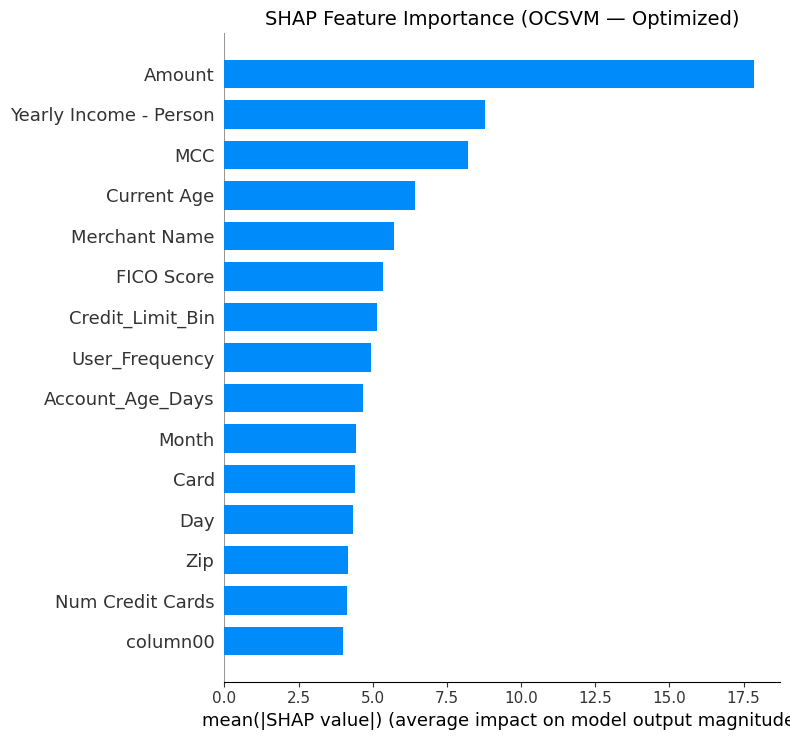

In [ ]:
import shap
import cloudpickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from scipy.sparse import issparse
import time

try:
    SHAP_KMEANS_K
except NameError:
    SHAP_KMEANS_K = 20

try:
    SHAP_NSAMPLES
except NameError:
    SHAP_NSAMPLES = 128

try:
    MAX_EVAL_SAMPLES
except NameError:
    MAX_EVAL_SAMPLES = 50

try:
    L1_REG_FEATURES
except NameError:
    L1_REG_FEATURES = 15

preprocessor_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/preprocessors")
preprocessor_file = preprocessor_dir / f"preprocessor_{PREPROCESSOR_TYPE}.pkl"

print(f"Loading preprocessor '{PREPROCESSOR_TYPE}' from {preprocessor_file}...")
with open(preprocessor_file, "rb") as f:
    preprocessor = cloudpickle.load(f)

def get_feature_names_manually(ct, model):
    """
    Manually reconstructs feature names from the ColumnTransformer, using the
    trained scikit-learn model as the source of truth for the final feature count.
    """
    num_cols = [c for name, trans, c in ct.transformers_ if name == 'num'][0]
    lowc_pipeline = ct.named_transformers_['lowc']
    ohe_names = list(lowc_pipeline.get_feature_names_out())
    interpretable_names = num_cols + ohe_names

    n_total_features = model.n_features_in_
    n_hashed = n_total_features - len(interpretable_names)
    hash_names = [f'hashed_feature_{i}' for i in range(n_hashed)]
    return interpretable_names + hash_names

original_feature_names = get_feature_names_manually(preprocessor, ocsvm_model)
print(f"Successfully reconstructed {len(original_feature_names)} feature names.")

def to_dense(x):
    return x.toarray() if issparse(x) else x

background_dense = to_dense(background_data).astype(np.float32, copy=False)
eval_dense_all = to_dense(eval_data).astype(np.float32, copy=False)

kmeans_k = min(SHAP_KMEANS_K, background_dense.shape[0])
print(f"Summarizing background from {background_dense.shape[0]} → {kmeans_k} via k-means...")
background_summary = shap.kmeans(background_dense, kmeans_k)

if eval_dense_all.shape[0] > MAX_EVAL_SAMPLES:
    eval_dense = eval_dense_all[:MAX_EVAL_SAMPLES]
    print(f"Explaining {eval_dense.shape[0]} rows (capped) out of {eval_dense_all.shape[0]} total.")
else:
    eval_dense = eval_dense_all
    print(f"Explaining {eval_dense.shape[0]} rows (no cap needed).")

print("\nComputing SHAP values for OCSVM with KernelExplainer (optimized)...")
predict_fn = lambda x: ocsvm_model.decision_function(x)

t0 = time.time()
explainer = shap.KernelExplainer(predict_fn, background_summary)
shap_values_ocsvm = explainer.shap_values(
    eval_dense,
    nsamples=SHAP_NSAMPLES,
    l1_reg=f"num_features({L1_REG_FEATURES})"
)
t1 = time.time()
print(f"SHAP done in {t1 - t0:.2f} s "
      f"(nsamples={SHAP_NSAMPLES}, background_k={kmeans_k}, "
      f"rows={eval_dense.shape[0]}, l1={L1_REG_FEATURES}).")


print("\nPreparing plot by omitting hashed features...")
clean_feature_names = [re.sub(r'^(num|lowc|highc)__', '', name) for name in original_feature_names]
is_not_hashed_mask = np.array([not name.startswith('hashed_feature') for name in clean_feature_names])

shap_values_array = np.array(shap_values_ocsvm)

shap_values_for_plot = shap_values_array[:, is_not_hashed_mask]
eval_data_for_plot = eval_dense[:, is_not_hashed_mask]
feature_names_for_plot = np.array(clean_feature_names)[is_not_hashed_mask].tolist()

output_dir = RESULTS_DIR / "shap_plots"
output_dir.mkdir(parents=True, exist_ok=True)
plot_path = output_dir / f"shap_summary_bar_ocsvm_{PREPROCESSOR_TYPE}_interpretable_only_fastlike.png"

shap.summary_plot(
    shap_values_for_plot,
    features=eval_data_for_plot,
    feature_names=feature_names_for_plot,
    plot_type='bar',
    max_display=15,
    show=False
)
plt.title("SHAP Feature Importance (OCSVM — Optimized)", fontsize=14)
plt.tight_layout()
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Filtered SHAP summary plot saved to: {plot_path}")

plt.show()

## Explain with LIME TabularExplainer

In [ ]:
import lime
import lime.lime_tabular
from tqdm.notebook import tqdm
import pandas as pd
import cloudpickle

preprocessor_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/preprocessors")
preprocessor_file = preprocessor_dir / f"preprocessor_{PREPROCESSOR_TYPE}.pkl"

print(f"Loading preprocessor '{PREPROCESSOR_TYPE}' from {preprocessor_file}...")
with open(preprocessor_file, "rb") as f:
    preprocessor = cloudpickle.load(f)

def get_feature_names_manually(ct, model):
    """
    Manually reconstructs feature names from the ColumnTransformer, using the
    trained scikit-learn model as the source of truth for the final feature count.
    """
    num_cols = [c for name, trans, c in ct.transformers_ if name == 'num'][0]
    lowc_pipeline = ct.named_transformers_['lowc']
    ohe_names = list(lowc_pipeline.get_feature_names_out())
    interpretable_names = num_cols + ohe_names

    n_total_features = model.n_features_in_
    n_hashed = n_total_features - len(interpretable_names)

    hash_names = [f'hashed_feature_{i}' for i in range(n_hashed)]
    return interpretable_names + hash_names

# Generate the full list of original feature names
original_feature_names = get_feature_names_manually(preprocessor, ocsvm_model)
print(f"Successfully reconstructed {len(original_feature_names)} feature names.")

def to_dense(data):
    """Converts a sparse matrix to dense, otherwise returns the original array."""
    return data.toarray() if issparse(data) else data

print("--- Generating LIME Explanations for the Full Model ---")

def lime_predict_proba_ocsvm(model, instances, feature_names):
    """Creates a pseudo-probability output for LIME from a One-Class SVM."""
    # Ensure instances are dense and 2D for DataFrame creation
    instances_dense = to_dense(instances)
    if instances_dense.ndim == 1:
        instances_dense = instances_dense.reshape(1, -1)

    instances_df = pd.DataFrame(instances_dense, columns=feature_names)
    # Negate scores so that higher values indicate a higher probability of being an anomaly (Fraud)
    scores = -model.score_samples(instances_df)

    # Stack with a baseline of zeros and apply softmax-like scaling for probability distribution
    stacked_scores = np.vstack([np.zeros_like(scores), scores]).T
    probs = np.exp(stacked_scores - np.max(stacked_scores, axis=1, keepdims=True))
    return probs / np.sum(probs, axis=1, keepdims=True)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=background_data,
    feature_names=original_feature_names,
    class_names=['Normal', 'Fraud'],
    mode='classification',
    kernel_width=LIME_KERNEL_WIDTH,
    discretize_continuous=True,
    random_state=RANDOM_STATE
)

lime_explanations_full = []
predict_fn = lambda x: lime_predict_proba_ocsvm(ocsvm_model, x, original_feature_names)

for i in tqdm(range(EVAL_PANEL_SIZE), desc="Generating LIME Explanations"):
    exp = lime_explainer.explain_instance(
        eval_data[i],
        predict_fn,
        num_features=LIME_NUM_FEATURES,
        num_samples=LIME_NUM_SAMPLES
    )
    lime_explanations_full.append(exp.as_list(label=1))

print("LIME explanation generation complete.")

Loading preprocessor 'kernel' from /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/preprocessors/preprocessor_kernel.pkl...
Successfully reconstructed 165 feature names.
--- Generating LIME Explanations for the Full Model ---


Generating LIME Explanations:   0%|          | 0/200 [00:00<?, ?it/s]

LIME explanation generation complete.


## LIME Stability Test

In [ ]:
from itertools import combinations

print("--- Running LIME Stability Test ---")

INSTANCE_INDEX_TO_TEST = 5
instance_to_test = eval_data[INSTANCE_INDEX_TO_TEST]
print(f"Testing instance #{INSTANCE_INDEX_TO_TEST} over {LIME_STABILITY_RUNS} runs...")

top_k_feature_sets = []
for i in range(LIME_STABILITY_RUNS):
    # Re-initialize the explainer with a new random seed for each run
    explainer_for_stability = lime.lime_tabular.LimeTabularExplainer(
        training_data=background_data,
        feature_names=original_feature_names,
        class_names=['Normal', 'Fraud'],
        mode='classification',
        kernel_width=LIME_KERNEL_WIDTH,
        random_state=RANDOM_STATE + i
    )
    explanation = explainer_for_stability.explain_instance(
        instance_to_test,
        predict_fn,
        num_features=LIME_NUM_FEATURES,
        num_samples=LIME_NUM_SAMPLES
    )
    top_features = {re.split(r' [<>]=? ', feat)[0] for feat, w in explanation.as_list(label=1)[:LIME_STABILITY_TOP_K]}
    top_k_feature_sets.append(top_features)

jaccard_scores = [len(s1.intersection(s2)) / len(s1.union(s2)) for s1, s2 in combinations(top_k_feature_sets, 2)]
lime_stability_score = np.mean(jaccard_scores) if jaccard_scores else 0.0

print(f"Average Jaccard Similarity: {lime_stability_score:.4f}")
if lime_stability_score >= 0.7:
    print("Result: This indicates a HIGHLY STABLE explanation.")
elif lime_stability_score >= 0.5:
    print("Result: This indicates a MODERATELY STABLE explanation.")
else:
    print("Result: This indicates LOW STABILITY. Consider increasing LIME_NUM_SAMPLES.")

--- Running LIME Stability Test ---
Testing instance #5 over 5 runs...
Average Jaccard Similarity: 0.0222
Result: This indicates LOW STABILITY. Consider increasing LIME_NUM_SAMPLES.


### Explainable Model

In [ ]:
print("--- Training Interpretable-Only One-Class SVM (Two-Models Strategy) ---")

is_interpretable_mask = [not name.startswith('hashed_feature') for name in original_feature_names]
interpretable_feature_names = np.array(original_feature_names)[is_interpretable_mask].tolist()

X_train_sample_interp = to_dense(X_train_sample)[:, is_interpretable_mask]
X_test_interp = to_dense(X_test)[:, is_interpretable_mask]
print(f"Training a new model on {len(interpretable_feature_names)} interpretable features.")

ocsvm_model_interpretable = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)
ocsvm_model_interpretable.fit(X_train_sample_interp)
print("Interpretable model trained successfully.")

y_pred_raw_interp = ocsvm_model_interpretable.predict(X_test_interp)
y_pred_interp = np.where(y_pred_raw_interp == -1, 1, 0)
performance_interpretable = {
    'f1_score': f1_score(y_test, y_pred_interp),
    'precision': precision_score(y_test, y_pred_interp),
    'recall': recall_score(y_test, y_pred_interp)
}
print("\nPerformance of the Interpretable-Only Model:")
print(json.dumps(performance_interpretable, indent=2))

joblib.dump(ocsvm_model_interpretable, RESULTS_DIR / f'ocsvm_model_{PREPROCESSOR_TYPE}_interpretable.joblib')
print(f"\nInterpretable model saved.")

--- Training Interpretable-Only One-Class SVM (Two-Models Strategy) ---
Training a new model on 36 interpretable features.
Interpretable model trained successfully.

Performance of the Interpretable-Only Model:
{
  "f1_score": 0.015088013411567477,
  "precision": 0.007996123091834261,
  "recall": 0.1334231805929919
}

Interpretable model saved.


In [ ]:
print("--- Generating LIME Explanations for the Interpretable-Only Model ---")

background_data_interp = to_dense(background_data)[:, is_interpretable_mask]
eval_data_interp = to_dense(eval_data)[:, is_interpretable_mask]

lime_explainer_interp = lime.lime_tabular.LimeTabularExplainer(
    training_data=background_data_interp,
    feature_names=interpretable_feature_names,
    class_names=['Normal', 'Fraud'],
    mode='classification',
    kernel_width=LIME_KERNEL_WIDTH,
    discretize_continuous=True,
    random_state=RANDOM_STATE
)

lime_explanations_interp = []

predict_fn_interp = lambda x: lime_predict_proba_ocsvm(ocsvm_model_interpretable, x, interpretable_feature_names)

for i in tqdm(range(EVAL_PANEL_SIZE), desc="Generating Interpretable LIME Explanations"):
    exp = lime_explainer_interp.explain_instance(
        eval_data_interp[i],
        predict_fn_interp,
        num_features=LIME_NUM_FEATURES,
        num_samples=LIME_NUM_SAMPLES
    )
    lime_explanations_interp.append(exp.as_list(label=1))

print("LIME explanation generation for the interpretable model is complete.")

--- Generating LIME Explanations for the Interpretable-Only Model ---


Generating Interpretable LIME Explanations:   0%|          | 0/200 [00:00<?, ?it/s]

LIME explanation generation for the interpretable model is complete.


In [ ]:
print("--- Running LIME Stability Test on Interpretable Model ---")

instance_to_test_interp = eval_data_interp[INSTANCE_INDEX_TO_TEST]
print(f"Testing instance #{INSTANCE_INDEX_TO_TEST} over {LIME_STABILITY_RUNS} runs...")

top_k_feature_sets_interp = []
for i in range(LIME_STABILITY_RUNS):
    explainer_for_stability_interp = lime.lime_tabular.LimeTabularExplainer(
        training_data=background_data_interp,
        feature_names=interpretable_feature_names,
        class_names=['Normal', 'Fraud'],
        mode='classification',
        kernel_width=LIME_KERNEL_WIDTH,
        random_state=RANDOM_STATE + i
    )
    explanation = explainer_for_stability_interp.explain_instance(
        instance_to_test_interp,
        predict_fn_interp,
        num_features=LIME_NUM_FEATURES,
        num_samples=LIME_NUM_SAMPLES
    )
    top_features = {re.split(r' [<>]=? ', feat)[0] for feat, w in explanation.as_list(label=1)[:LIME_STABILITY_TOP_K]}
    top_k_feature_sets_interp.append(top_features)

# Calculate the Jaccard similarity for the interpretable model's explanations
jaccard_scores_interp = [len(s1.intersection(s2)) / len(s1.union(s2)) for s1, s2 in combinations(top_k_feature_sets_interp, 2)]
lime_stability_score_interp = np.mean(jaccard_scores_interp) if jaccard_scores_interp else 0.0

print(f"Average Jaccard Similarity (Interpretable Model): {lime_stability_score_interp:.4f}")
if lime_stability_score_interp >= 0.7:
    print("Result: This indicates a HIGHLY STABLE explanation.")
else:
    print("Result: This may indicate a less stable explanation. Consider parameter tuning.")

--- Running LIME Stability Test on Interpretable Model ---
Testing instance #5 over 5 runs...
Average Jaccard Similarity (Interpretable Model): 0.1151
Result: This may indicate a less stable explanation. Consider parameter tuning.


## Interpretability Metrics

In [ ]:
from itertools import combinations
from tqdm.notebook import tqdm

# Define OCSVM-Specific Anomaly Score Function
def get_anomaly_scores_ocsvm(model, X_data):
    """
    Calculates anomaly scores for the OCSVM. The output is negated so that
    higher scores indicate a higher degree of anomaly.
    """
    return -model.score_samples(X_data)

def compute_deletion_auc_lime(model, eval_data, lime_explanations, feature_names, max_features=10):
    """Computes Faithfulness using the feature deletion method (Area Under the Curve)."""
    eval_arr = to_dense(eval_data)
    feat_to_idx = {feat: i for i, feat in enumerate(feature_names)}
    total_aucs = []

    for idx, exp in tqdm(enumerate(lime_explanations), total=len(lime_explanations), desc="LIME Faithfulness"):
        original = eval_arr[idx].reshape(1, -1)
        lime_features = [re.split(r' [<>]=? ', feat)[0] for feat, _ in exp.as_list(label=1)]
        ranked_idxs = [feat_to_idx[feat] for feat in lime_features if feat in feat_to_idx]

        scores = []
        for k in range(1, min(max_features, len(ranked_idxs)) + 1):
            masked = original.copy()
            masked[0, ranked_idxs[:k]] = 0
            new_score = get_anomaly_scores_ocsvm(model, masked)[0]
            scores.append(new_score)

        if not scores: continue
        auc = np.trapezoid(y=scores, x=list(range(1, len(scores) + 1))) / len(scores)
        total_aucs.append(auc)

    return np.mean(total_aucs) if total_aucs else 0.0

def compute_sparsity_lime(lime_explanations):
    """Computes Sparsity as the proportion of features used in an explanation."""
    num_total_features = len(interpretable_feature_names)
    if num_total_features == 0: return 0.0
    sparsity_scores = [len(exp.as_list(label=1)) / num_total_features for exp in lime_explanations]
    return np.mean(sparsity_scores)

def compute_stability_lime(lime_explanations, top_k=5):
    """Computes Stability by comparing the consistency of top features across all generated explanations."""
    feature_sets = [{re.split(r' [<>]=? ', f)[0] for f, w in exp.as_list(label=1)[:top_k]} for exp in lime_explanations]
    if len(feature_sets) < 2: return 0.0
    jaccard_scores = [len(s1.intersection(s2)) / len(s1.union(s2)) for s1, s2 in combinations(feature_sets, 2) if len(s1.union(s2)) > 0]
    return np.mean(jaccard_scores) if jaccard_scores else 0.0

def compute_complexity_lime(lime_explanations):
    """Computes Complexity as the average number of features per explanation."""
    return np.mean([len(exp.as_list(label=1)) for exp in lime_explanations])

# SHAP Metrics
def compute_sparsity_shap(shap_values):
    """Computes Sparsity as the proportion of non-zero SHAP values."""
    return np.mean(shap_values != 0)

def compute_stability_shap(shap_values, feature_names, top_k=5):
    """Computes Stability by comparing the consistency of top SHAP features across instances."""
    feature_rankings = np.argsort(np.abs(shap_values), axis=1)[:, ::-1]
    top_k_sets = [set(np.array(feature_names)[indices]) for indices in feature_rankings[:, :top_k]]
    if len(top_k_sets) < 2: return 0.0
    jaccard_scores = [len(s1.intersection(s2)) / len(s1.union(s2)) for s1, s2 in combinations(top_k_sets, 2) if len(s1.union(s2)) > 0]
    return np.mean(jaccard_scores) if jaccard_scores else 0.0

def compute_complexity_shap(shap_values):
    """Computes Complexity as the average number of non-zero SHAP values per instance."""
    return np.mean(np.sum(shap_values != 0, axis=1))


print("Generating LIME explanations for the full evaluation panel for metric calculation...")
lime_explanations_for_metrics = [lime_explainer_interp.explain_instance(
    instance, predict_fn_interp, num_features=LIME_NUM_FEATURES, num_samples=LIME_NUM_SAMPLES
) for instance in eval_data_interp]
print("LIME explanations for panel generated.")


metrics_interpretable = {
    'Faithfulness (LIME)': compute_deletion_auc_lime(ocsvm_model_interpretable, eval_data_interp, lime_explanations_for_metrics, interpretable_feature_names),
    'Sparsity (LIME)': compute_sparsity_lime(lime_explanations_for_metrics),
    'Stability (LIME)': compute_stability_lime(lime_explanations_for_metrics, top_k=5),
    'Complexity (LIME)': compute_complexity_lime(lime_explanations_for_metrics)
}
metrics_full = {
    'Sparsity (SHAP)': compute_sparsity_shap(shap_values_ocsvm),
    'Stability (SHAP)': compute_stability_shap(shap_values_ocsvm, clean_feature_names, top_k=5),
    'Complexity (SHAP)': compute_complexity_shap(shap_values_ocsvm)
}

print(f"\n=== Interpretability Metrics (OCSVM - {PREPROCESSOR_TYPE}) ===")
print("\n--- Interpretable Model Metrics (via LIME) ---")
for name, value in metrics_interpretable.items():
    print(f"{name:<22}: {value:.4f}")
print("\n--- Full Model Metrics (via SHAP) ---")
for name, value in metrics_full.items():
    print(f"{name:<22}: {value:.4f}")

interpretability_metrics = {**metrics_interpretable, **metrics_full}

Generating LIME explanations for the full evaluation panel for metric calculation...
LIME explanations for panel generated.


LIME Faithfulness:   0%|          | 0/200 [00:00<?, ?it/s]


=== Interpretability Metrics (OCSVM - kernel) ===

--- Interpretable Model Metrics (via LIME) ---
Faithfulness (LIME)   : -738.3185
Sparsity (LIME)       : 0.4167
Stability (LIME)      : 0.0722
Complexity (LIME)     : 15.0000

--- Full Model Metrics (via SHAP) ---
Sparsity (SHAP)       : 0.0909
Stability (SHAP)      : 0.1659
Complexity (SHAP)     : 15.0000


## Logging for Documentation

In [ ]:
import json
import pandas as pd
import numpy as np
from pathlib import Path

# Helper Class for JSON Serialization
class NpEncoder(json.JSONEncoder):
    """Custom JSON encoder for numpy types."""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def log_results(
    model_name: str,
    preprocessor_type: str,
    hyperparams: dict,
    performance_metrics: dict,
    interpretability_metrics: dict,
    explainer_params: dict,
    shap_values: np.ndarray,
    clean_feature_names: list,
    lime_explanations: list,
    eval_indices: np.ndarray,
    base_dir: Path
):
    """Saves all relevant metrics and explanation artifacts into a structured directory."""
    run_dir = base_dir / f"{model_name.lower().replace(' ', '')}_{preprocessor_type}_run"
    explain_dir = run_dir / "explanations"
    metrics_dir = run_dir / "metrics"

    run_dir.mkdir(parents=True, exist_ok=True)
    explain_dir.mkdir(exist_ok=True)
    metrics_dir.mkdir(exist_ok=True)

    with open(metrics_dir / "hyperparameters.json", "w") as f:
        json.dump(hyperparams, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "performance_metrics.json", "w") as f:
        json.dump(performance_metrics, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "interpretability_metrics.json", "w") as f:
        json.dump(interpretability_metrics, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "explainer_params.json", "w") as f:
        json.dump(explainer_params, f, indent=4, cls=NpEncoder)

    if shap_values.size > 0:
        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
        shap_df = pd.DataFrame({'feature': clean_feature_names, 'mean_abs_shap_value': mean_abs_shap})
        shap_df = shap_df.sort_values(by='mean_abs_shap_value', ascending=False)
        shap_df.to_csv(explain_dir / "shap_aggregated_importances.csv", index=False)

    if lime_explanations:
        lime_out = [
            {"eval_panel_index": int(eval_indices[i]), "explanation": exp.as_list(label=1)}
            for i, exp in enumerate(lime_explanations)
        ]
        with open(explain_dir / "lime_explanations.json", "w") as f:
            json.dump(lime_out, f, indent=4, cls=NpEncoder)

    print(f"All artifacts for '{model_name}' saved to: '{run_dir}'")

explainer_parameters = {
    'background_size': BACKGROUND_SIZE,
    'shap_kmeans_k': SHAP_KMEANS_K,
    'shap_nsamples': SHAP_NSAMPLES,
    'lime_kernel_width': LIME_KERNEL_WIDTH,
    'lime_num_samples': LIME_NUM_SAMPLES,
    'lime_num_features': LIME_NUM_FEATURES
}

ocsvm_hyperparams_full = {
    "model_type": "Full",
    **ocsvm_model.get_params()
}

ocsvm_hyperparams_interpretable = {
    "model_type": "Interpretable Only",
    **ocsvm_model_interpretable.get_params()
}

eval_indices = np.arange(EVAL_PANEL_SIZE)
results_base_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results")


print("\n--- Logging Full Model Results ---")
log_results(
    model_name="OCSVM_Full",
    preprocessor_type=PREPROCESSOR_TYPE,
    hyperparams=ocsvm_hyperparams_full,
    performance_metrics=model_performance,
    interpretability_metrics=metrics_full,
    explainer_params=explainer_parameters,
    shap_values=shap_values_ocsvm,
    clean_feature_names=clean_feature_names,
    lime_explanations=[], # No LIME explanations for this log
    eval_indices=eval_indices,
    base_dir=results_base_dir
)

print("\n--- Logging Interpretable Model Results ---")
log_results(
    model_name="OCSVM_Interpretable",
    preprocessor_type=PREPROCESSOR_TYPE,
    hyperparams=ocsvm_hyperparams_interpretable,
    performance_metrics=performance_interpretable,
    interpretability_metrics=metrics_interpretable,
    explainer_params=explainer_parameters,
    shap_values=np.array([]), # No SHAP values for this log
    clean_feature_names=interpretable_feature_names,
    lime_explanations=lime_explanations_for_metrics,
    eval_indices=eval_indices,
    base_dir=results_base_dir
)


--- Logging Full Model Results ---
All artifacts for 'OCSVM_Full' saved to: '/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/ocsvm_full_kernel_run'

--- Logging Interpretable Model Results ---
All artifacts for 'OCSVM_Interpretable' saved to: '/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/ocsvm_interpretable_kernel_run'
